In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os 
import osmnx as ox
import networkx as nx
import sys
from pathlib import Path
sys.path.append(str(Path(os.getcwd()).parent.parent))
from src.plotting.styles import get_style, latex_escape

### Distance and Correlation

This Jupyter Notebook analyzes the spatial distances and correlations of bicycle counters in German cities. It allows you to check correlations between different counting sites and visualize the results.

The notebook is flexible: the city can be changed in Block 10 to run the analysis for any city with eco-counters.

1. Euclidean Distance: Compute straight-line distances between all counters in a city.
2. Bike Distance: Calculate realistic cycling distances along streets and bike paths.
3. Correlation: Check if counting sites show similar cycling activity patterns.
4. Visualization: Display distances and correlations for easy interpretation.

##### Supported Cities and Number of Eco-Counters

- "Stadt Heidelberg": 15 counter
- "Landeshauptstadt Stuttgart": 15 counter
- "Stadt Ludwigsburg": 15 counter
- "Stadt Mannheim": 14 counter
- "Stadt Freiburg": 10 counter
- "Stadt Reutlingen": 7 counter
- "Stadt Konstanz": 6 counter
- "Stadt Tübingen": 5 counter
- "Stadt Heilbronn": 4 counter
- "Stadt Lörrach": 2 counter

In [2]:
# allow imports from src/
PROJECT_ROOT = Path.cwd().parents[1]
sys.path.insert(0, str(PROJECT_ROOT))

# import dataloader function
from src.data.dataload import load_csv_folder_to_dataframe

DATA_DIR = PROJECT_ROOT / "data/raw"
PLOTS_DIR = PROJECT_ROOT / "outputs/plots"
PROCESSED_DIR = PROJECT_ROOT / "data/processed"

# if df_all.csv exists load it as dataframe (faster), else load from raw data
df_all_path = PROCESSED_DIR / "df_all.csv"
if df_all_path.exists():
    print("Loading preprocessed dataframe from", df_all_path)
    df_all = pd.read_csv(df_all_path)
else:
    ## get data and preprocess
    df_all = load_csv_folder_to_dataframe(DATA_DIR)

##  timestamps to datetime
df_all['iso_timestamp'] = pd.to_datetime(df_all['iso_timestamp'], utc=True, format='mixed')

# change columns to numerics
numeric_cols = [
    "channels_in", "channels_out", "channels_unknown", "channels_all", 
    "site_temperature", "site_rain_accumulation", "site_snow_accumulation"]

df_all[numeric_cols] = df_all[numeric_cols].apply(pd.to_numeric, errors='coerce')

df_all["count"] = df_all[["channels_out", "channels_in", "channels_unknown"]].fillna(0).sum(axis=1)

# subset of dataframe just for one town 
df_domain = df_all[df_all["domain_name"] == "Stadt Tübingen"] ### change domain name here for other towns
title_domain = df_domain["domain_name"].iloc[0]
print(title_domain)
df_domain_grouped = df_domain.groupby("counter_site")

# get coordinates for every counter site
domain_coords = {
    name: (
        df_domain_grouped.get_group(name)["latitude"].iloc[0],
        df_domain_grouped.get_group(name)["longitude"].iloc[0]
    )
    for name in df_domain_grouped.groups.keys()
}
domain_coords

Loading preprocessed dataframe from /Users/davidsuckrow/Documents/Developing/Data Literacy/fahrradzaehler/data/processed/df_all.csv


KeyboardInterrupt: 

#### 1. Euclidean Distance

In this step, we compute the Euclidean (straight-line) distance between all counter sites based on their geographic coordinates.

We first convert the latitude and longitude from degrees to a Cartesian coordinate system using the following formula:

\begin{aligned}
x &= R \cdot \cos(\varphi_0) \cdot \mathrm{rad}(\lambda), \\
y &= R \cdot \mathrm{rad}(\varphi),
\end{aligned}
where
$\mathrm{rad}(\alpha) = \alpha \cdot \frac{\pi}{180}$

Variables:
- $\varphi$ : latitude in degrees 
- $\lambda$ : longitude in degrees 
- $\varphi_0$ : reference latitude
- $R = 6{,}371{,}000\,\text{m}$ : earth radius

Once converted to Cartesian coordinates, the Euclidean distance $d_{ij}$ between two counters $i$ and $j$ is computed as:

$d_{ij} = \sqrt{(x_i - x_j)^2 + (y_i - y_j)^2}$

**Output:**  
A symmetric **distance matrix** where each element $(i,j)$ represents the straight-line distance between counter $i$ and counter $j$



In [ ]:
# 1.1 reference latitude for the conversion
lat0 = np.mean([coord[0] for coord in domain_coords.values()])

# 1.2 define function to convert lat/lon to x/y in meters
def latlon_to_xy(coord, lat0=lat0):
    lat, lon = coord
    R = 6371000 # radius of earth in meters
    x = R * np.radians(lon) * np.cos(np.radians(lat0))
    y = R * np.radians(lat)
    return np.array([x, y])

# 1.3 distance matrix
sites1 = list(domain_coords.keys())
dist_matrix_euclid = pd.DataFrame(index=sites1, columns=sites1, dtype=float)
# compute euclidean distances and fill the distance matrix
for a in sites1:
    for b in sites1:
        p1 = latlon_to_xy(domain_coords[a])
        p2 = latlon_to_xy(domain_coords[b])
        dist_matrix_euclid.loc[a, b] = np.linalg.norm(p1 - p2)

#### 2. Bike Distance

In this step, we compute the realistic cycling distance between counter sites using the **Osmnx** package, which builds a graph of streets and bike paths.  

1. **Create a graph:**  
   - We define a **center node** as the mean latitude and longitude of all counter sites.  
   - The **network type** is set to `"bike"` to include only bike-accessible streets and paths.  
   - The **radius** is chosen as the maximum Euclidean distance between all counter sites to ensure all sites are included in the graph.  

2. **Calculate distances:**  
   - We use `nx.shortest_path_length()` from NetworkX to compute the shortest path (bike distance) between all pairs of counters on the graph.  
   - The results are stored in a **distance matrix**, similar in format to the Euclidean distance matrix.  

**Output:**  
A symmetric **bike distance matrix** where each element $(i,j)$ represents the shortest cycling distance between counter $i$ and counter $j$.

In [ ]:
# 2.1 create graph from OSM streetmaps
# compute mean of lats and lons for center point
lats = [coord[0] for coord in domain_coords.values()]
cp_lat = np.mean(lats)
lons = [coord[1] for coord in domain_coords.values()]
cp_lon = np.mean(lons)
# set mean as center point 
center_point = (cp_lat, cp_lon)  

# max euclidean distance between sites to ensure all sites are within graph area
max_euclid_dist = max(
    dist_matrix_euclid.loc[site, site2]
    for site in sites1
    for site2 in sites1
)
print(max_euclid_dist)

# access streetmaps graph with bike lanes, with median cp and 3km radius (adjust if needed)
G = ox.graph_from_point(center_point, dist=max_euclid_dist, network_type='bike')
# nodes in our graph are our counter sites 
snapped_nodes = {}
for name, (lat, lon) in domain_coords.items():
    node = ox.distance.nearest_nodes(G, X=lon, Y=lat)
    snapped_nodes[name] = node

# 2.2 compute shortest path distances between all counter sites
distances1 = {}
for i in snapped_nodes:
    for j in snapped_nodes:
        if (j, i) in distances1:
            distances1[(i, j)] = distances1[(j, i)]
            continue
        if i == j:
            distances1[(i, j)] = 0
            continue
        d = nx.shortest_path_length(G, snapped_nodes[i], snapped_nodes[j], weight='length')
        distances1[(i, j)] = d
        print(f"distance between {i} and {j}: {d:.1f} m")


# create distance matrix (for bike dist)
dist_matrix = pd.DataFrame(index=sites1, columns=sites1)
for (site1, site2), dist in distances1.items():
    dist_matrix.loc[site1, site2] = dist
    dist_matrix.loc[site2, site1] = dist

# fill diagonal with 0
dist_matrix.fillna(0, inplace=True)

3634.268678406692
distance between Fuß- & Radtunnel Südportal - Derendinger Allee and Neckartalradweg Hirschau - parallel L371: 2521.1 m
distance between Fuß- & Radtunnel Südportal - Derendinger Allee and Radbrücke Mitte - Wöhrdstraße: 1142.7 m
distance between Fuß- & Radtunnel Südportal - Derendinger Allee and Radbrücke Ost: 1906.1 m
distance between Fuß- & Radtunnel Südportal - Derendinger Allee and Unterführung Steinlach/Karlstraße Südseite - Steinlachallee: 1353.0 m
distance between Neckartalradweg Hirschau - parallel L371 and Radbrücke Mitte - Wöhrdstraße: 3613.8 m
distance between Neckartalradweg Hirschau - parallel L371 and Radbrücke Ost: 4377.2 m
distance between Neckartalradweg Hirschau - parallel L371 and Unterführung Steinlach/Karlstraße Südseite - Steinlachallee: 3748.0 m
distance between Radbrücke Mitte - Wöhrdstraße and Radbrücke Ost: 878.2 m
distance between Radbrücke Mitte - Wöhrdstraße and Unterführung Steinlach/Karlstraße Südseite - Steinlachallee: 479.2 m
distance be

#### Optional

The next cell block is mainly to plot the routes between two respective counter sites (uncomment the last line of the loop). For Tübingen this is not too much as

$\binom{n}{2} = \frac{n(n-1)}{2}$

so for 5 stations 

$\binom{5}{2} = \frac{5(5-1)}{2}=10$

but for cities like Ludwigsburg or Stuttgart we have 15 counters, so proceed with caution.

In [ ]:
# compute all the routes as well and store them in a dict
# you can plot it too! (uncomment last line)
routes = {}

keys = list(snapped_nodes.keys())

for i in keys:
    for j in keys:
        if (j, i) in routes:
            routes[(i, j)] = routes[(j, i)]
            continue
        if i == j:
            routes[(i, j)] = [snapped_nodes[i]]
            continue
        r = nx.shortest_path(G, snapped_nodes[i], snapped_nodes[j], weight='length')
        routes[(i, j)] = r
        # ox.plot_graph_route(G, r)



#### 3. Correlation

This section analyzes correlations between bicycle counts at different counter sites.

##### 3.1 Pivot Table

The data is reshaped into a pivot table where each column represents a counter site
and each row represents a timestamp. This format is required to compute correlations
between time series.

Only numerical count values are used. If multiple entries exist for the same timestamp,
they are aggregated using the sum.

Additionally, we compute how many timestamps overlap between each pair of sites.
This helps assess how reliable the computed correlations are.

##### 3.2 Correlation Matrix (All Available Data)

We compute the Pearson correlation matrix using all available overlapping data points.
Missing values are ignored pairwise.

The resulting correlation matrix is visualized as a heatmap to highlight similarities
and differences between counter sites.

##### 3.3 Correlation Matrix (Fully Aligned Data)

To ensure that all correlations are based on the same timestamps, we remove all rows
containing missing values.

The correlation matrix is recomputed using only fully aligned time series.
This provides a stricter and more conservative correlation estimate.

##### 3.4 Difference Between Correlation Matrices

Finally, we compute the difference between the aligned and unaligned correlation matrices.

This highlights how much the correlation values change when missing data is excluded
entirely, and helps identify correlations that are sensitive to data availability.

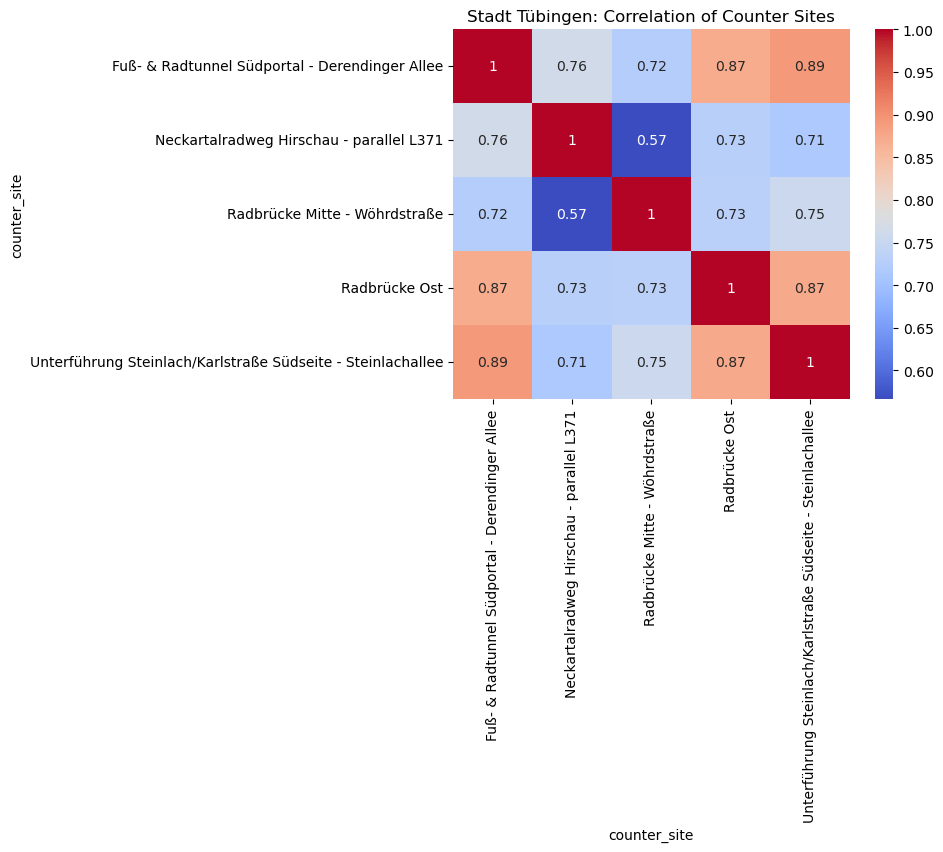

In [ ]:
# 3.1 pivot table for correlation matrix
df_domain_pivot = df_domain.pivot_table(
    index = 'iso_timestamp',
    columns = 'counter_site',
    values = 'count',
    aggfunc='sum'
)

# we want to see how many timestamps have data for both sites
mask = df_domain_pivot.notna().astype(int)
overlap = mask.T.dot(mask)
# 3.2 compute correlation matrix and plot heatmap
corr_matrix = df_domain_pivot.corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title(f"{title_domain}: Correlation of Counter Sites")
plt.show()

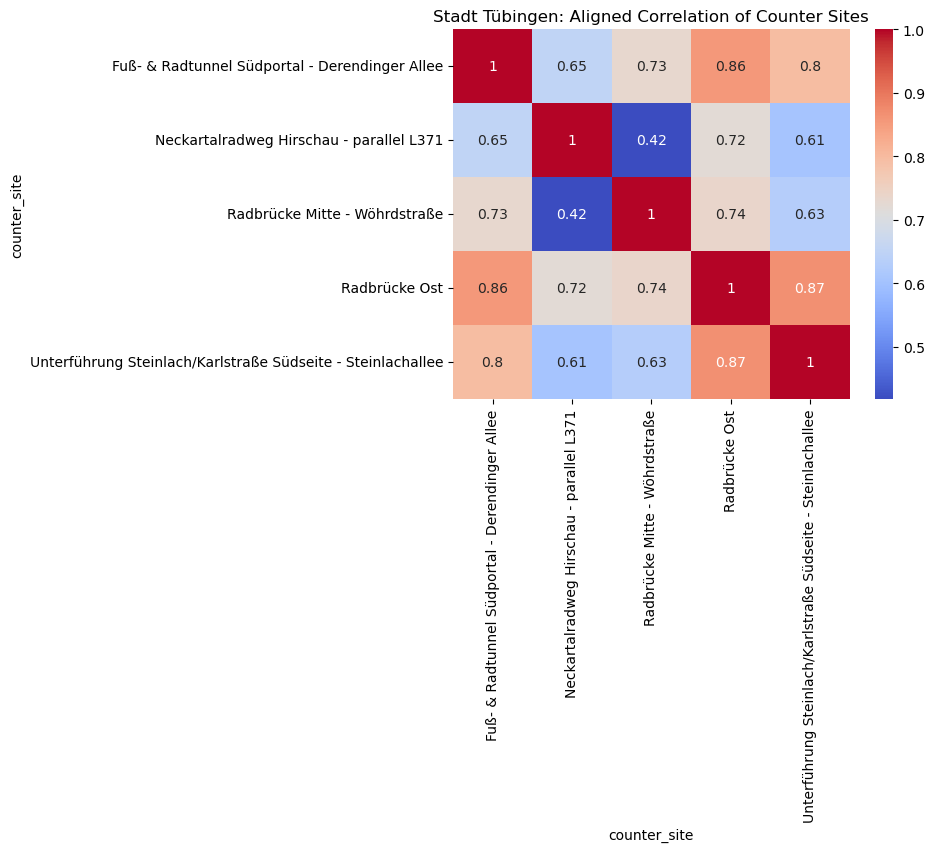

In [ ]:
# 3.3 correlation matrix for just times where all sites have data
aligned = df_domain_pivot.dropna()
corr_matrix1 = aligned.corr()
sns.heatmap(corr_matrix1, annot=True, cmap='coolwarm')
plt.title(f"{title_domain}: Aligned Correlation of Counter Sites")
plt.show()

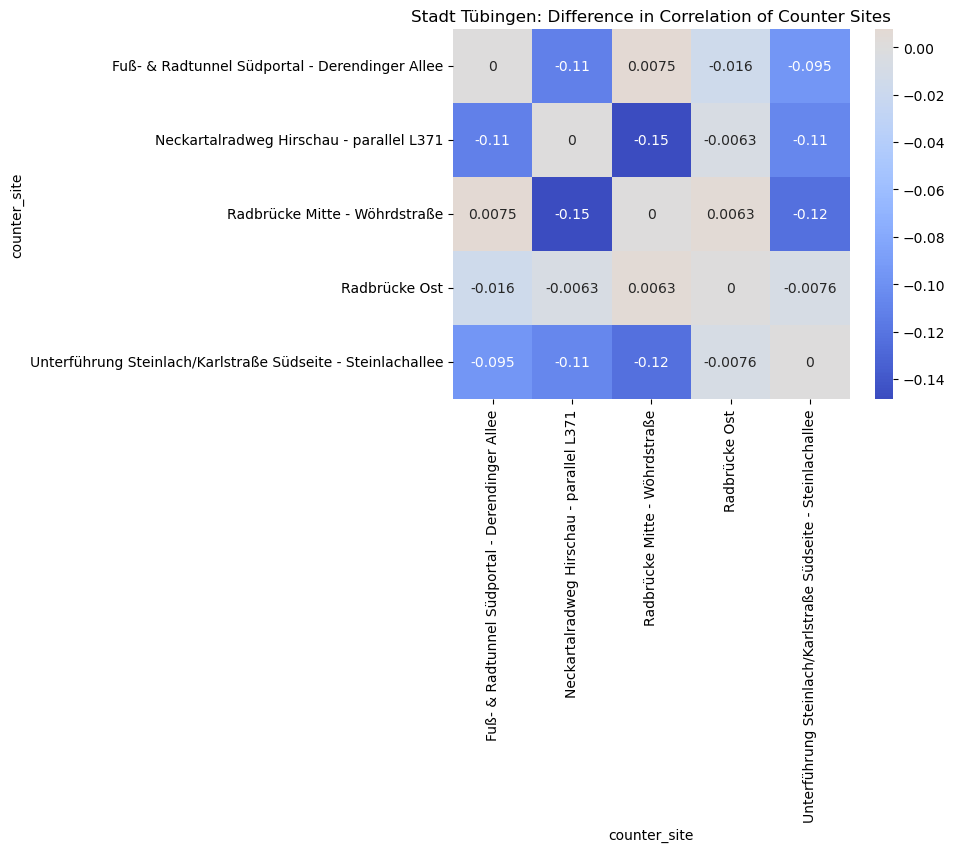

In [ ]:
# 3.4 difference between the two correlation matrices
corr_diff = corr_matrix1 - corr_matrix

sns.heatmap(corr_diff, annot=True, cmap='coolwarm', center=0)
plt.title(f"{title_domain}: Difference in Correlation of Counter Sites")
plt.show()

To assess the robustness of correlations across counter sites, we compared the correlation matrix computed from all available time points with the matrix computed only from time points where all sites were simultaneously active. The maximum difference observed between corresponding pairwise correlations was 0.15, indicating that the overall correlation structure is largely unaffected by differences in temporal coverage.

#### 4. Visualization

##### 4.1 Distance Measures

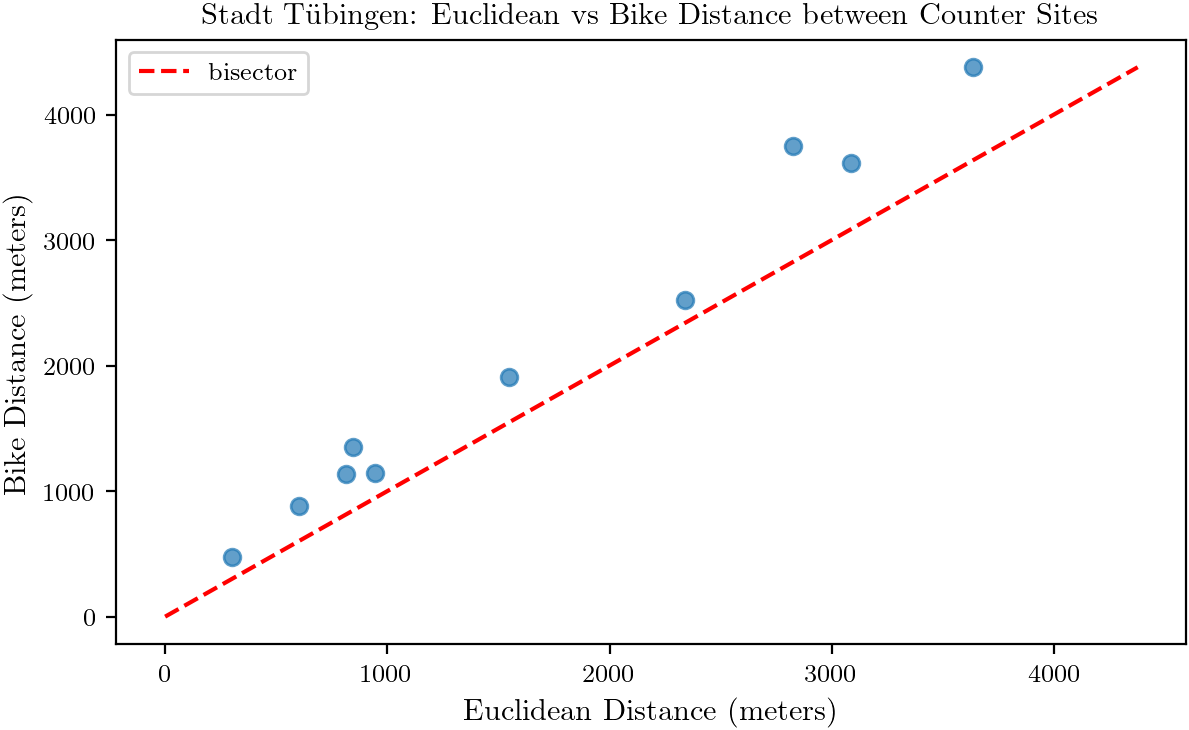

In [ ]:
# 4.1.1 check if any bike distances are shorter than euclidean distances (should not be possible)
dist_diff = dist_matrix - dist_matrix_euclid
if (dist_diff < 0).any().any():
    print("Some bike distances are shorter than euclidean distances.")

# 4.1.2 euclidean vs bike distance scatter plot
euclidean_distances = []
bike_distances = []
for site_a in sites1:
    for site_b in sites1:
        if site_a >= site_b:
            continue
        euclidean_distances.append(dist_matrix_euclid.loc[site_a, site_b])
        bike_distances.append(dist_matrix.loc[site_a, site_b])

with plt.rc_context(get_style(rel_width=1,display_dpi=200)):
    plt.scatter(euclidean_distances, bike_distances)
    ## we need a bisector line for reference (again check for correctness)
    max_dist = max(max(euclidean_distances), max(bike_distances))
    plt.plot([0, max_dist], [0, max_dist], color='red', linestyle='--', label='bisector')
    plt.legend()
    plt.xlabel("Euclidean Distance (meters)")
    plt.ylabel("Bike Distance (meters)")
    plt.title(f"{title_domain}: Euclidean vs Bike Distance between Counter Sites")
    plt.show()

Figure: Euclidean distance vs. Bike distance. The bisector line serves as a visual check whether any bike distance is shorter than euclidean distance. As bike distance should be higher than euclidean distance in any case, every point below the red line indicates an error.

##### 4.2 Distance and Correlation

In the last step we want to plot correlation against distance. 
We would predict that the further apart two counter sites are, the less correlated their counts are.

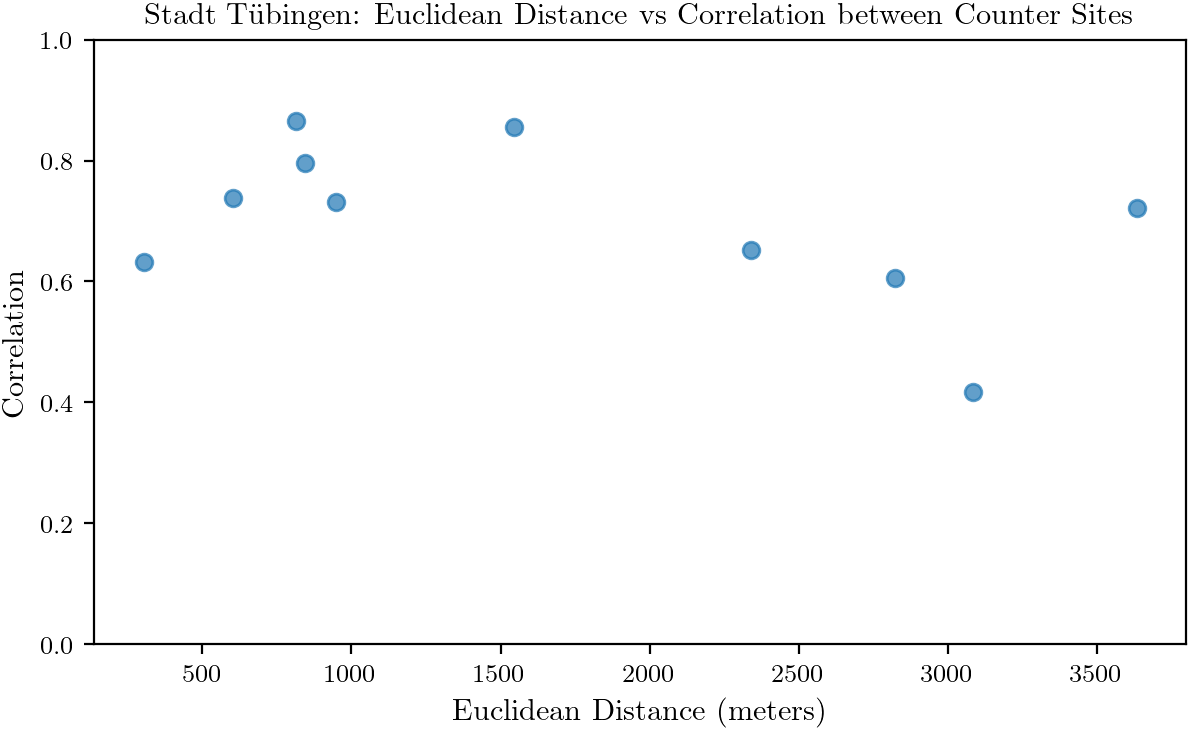

In [ ]:
# 4.2.1 euclidean distance vs correlation plot
correlations = []
distance_values = []
for i in range(len(sites1)):
    for j in range(i + 1, len(sites1)):
        site1 = sites1[i]
        site2 = sites1[j]
        distance = dist_matrix_euclid.loc[site1, site2]
        correlation = corr_matrix1.loc[site1, site2]
        distance_values.append(distance)
        correlations.append(correlation)

with plt.rc_context(get_style(rel_width=1,display_dpi=200)):
    plt.scatter(distance_values, correlations)
    plt.xlabel("Euclidean Distance (meters)")
    # set y limit to 0 and 1
    plt.ylim(0, 1)
    plt.ylabel("Correlation")
    plt.title(f"{title_domain}: Euclidean Distance vs Correlation between Counter Sites")
    plt.show()

Stadt: Stadt Tübingen


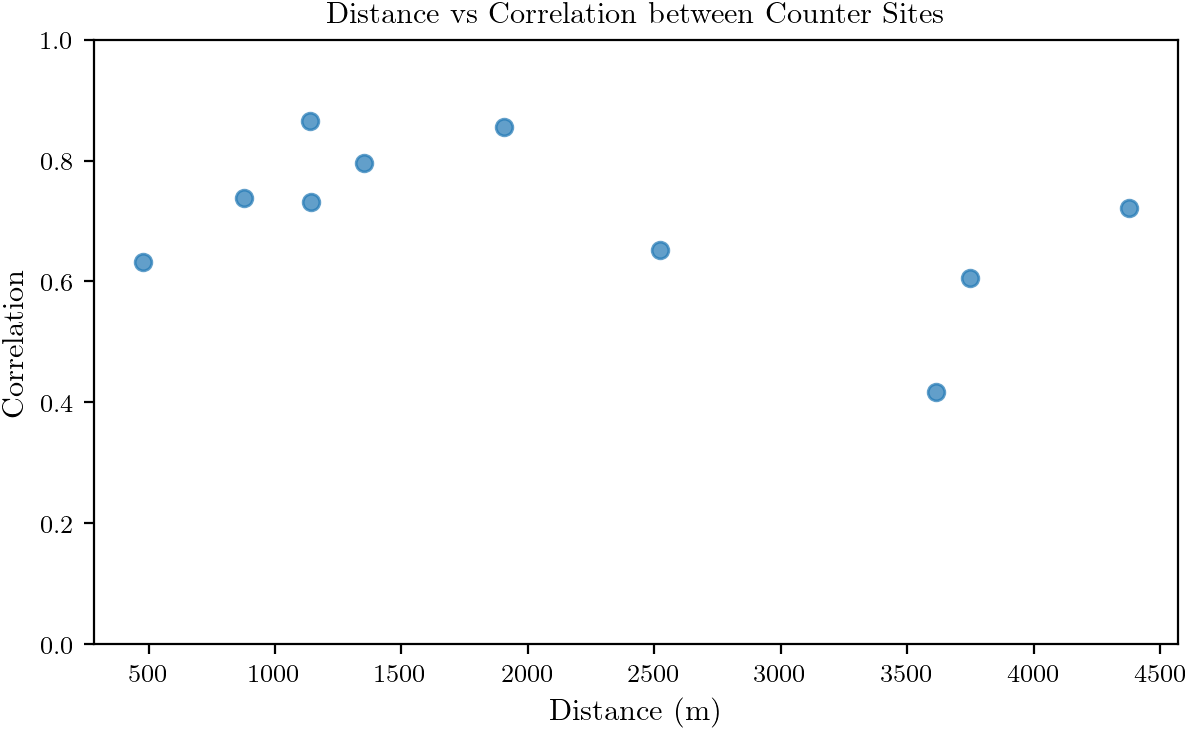

In [ ]:
# 4.2.2 bike distance vs correlation plot
correlations = []
distance_values = []
for i in range(len(sites1)):
    for j in range(i + 1, len(sites1)):
        site1 = sites1[i]
        site2 = sites1[j]
        distance = dist_matrix.loc[site1, site2]
        correlation = corr_matrix1.loc[site1, site2]
        distance_values.append(distance)
        correlations.append(correlation)
with plt.rc_context(get_style(rel_width=1,display_dpi=200)):
    print("Stadt:",title_domain)
    plt.scatter(distance_values, correlations)
    plt.xlabel("Distance (m)")
    plt.ylabel("Correlation")
    plt.ylim(0, 1)
    plt.title("Distance vs Correlation between Counter Sites")
    plt.show()

In [ ]:
################################################
# REGRESSION MODELING - SETUP                  #
################################################

import importlib
#sys.path.append(str(Path(os.getcwd()).parent.parent))
import src.model.regression_utils


# Load city data with features
df_city = pd.read_csv(PROCESSED_DIR / "df_features.csv")
df_city = df_city[df_city['domain_name'] == title_domain].copy()

print(f"✓ Loaded {len(df_city):,} hourly records for {title_domain}")
print(f"✓ {df_city['counter_site'].nunique()} stations")
print(f"✓ regression_utils.py reloaded")

✓ Loaded 333,542 hourly records for Stadt Tübingen
✓ 5 stations
✓ regression_utils.py reloaded


/var/folders/dn/vxwn6zk17qg5wl81t01zs03w0000gn/T/ipykernel_2943/3837346321.py:55: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


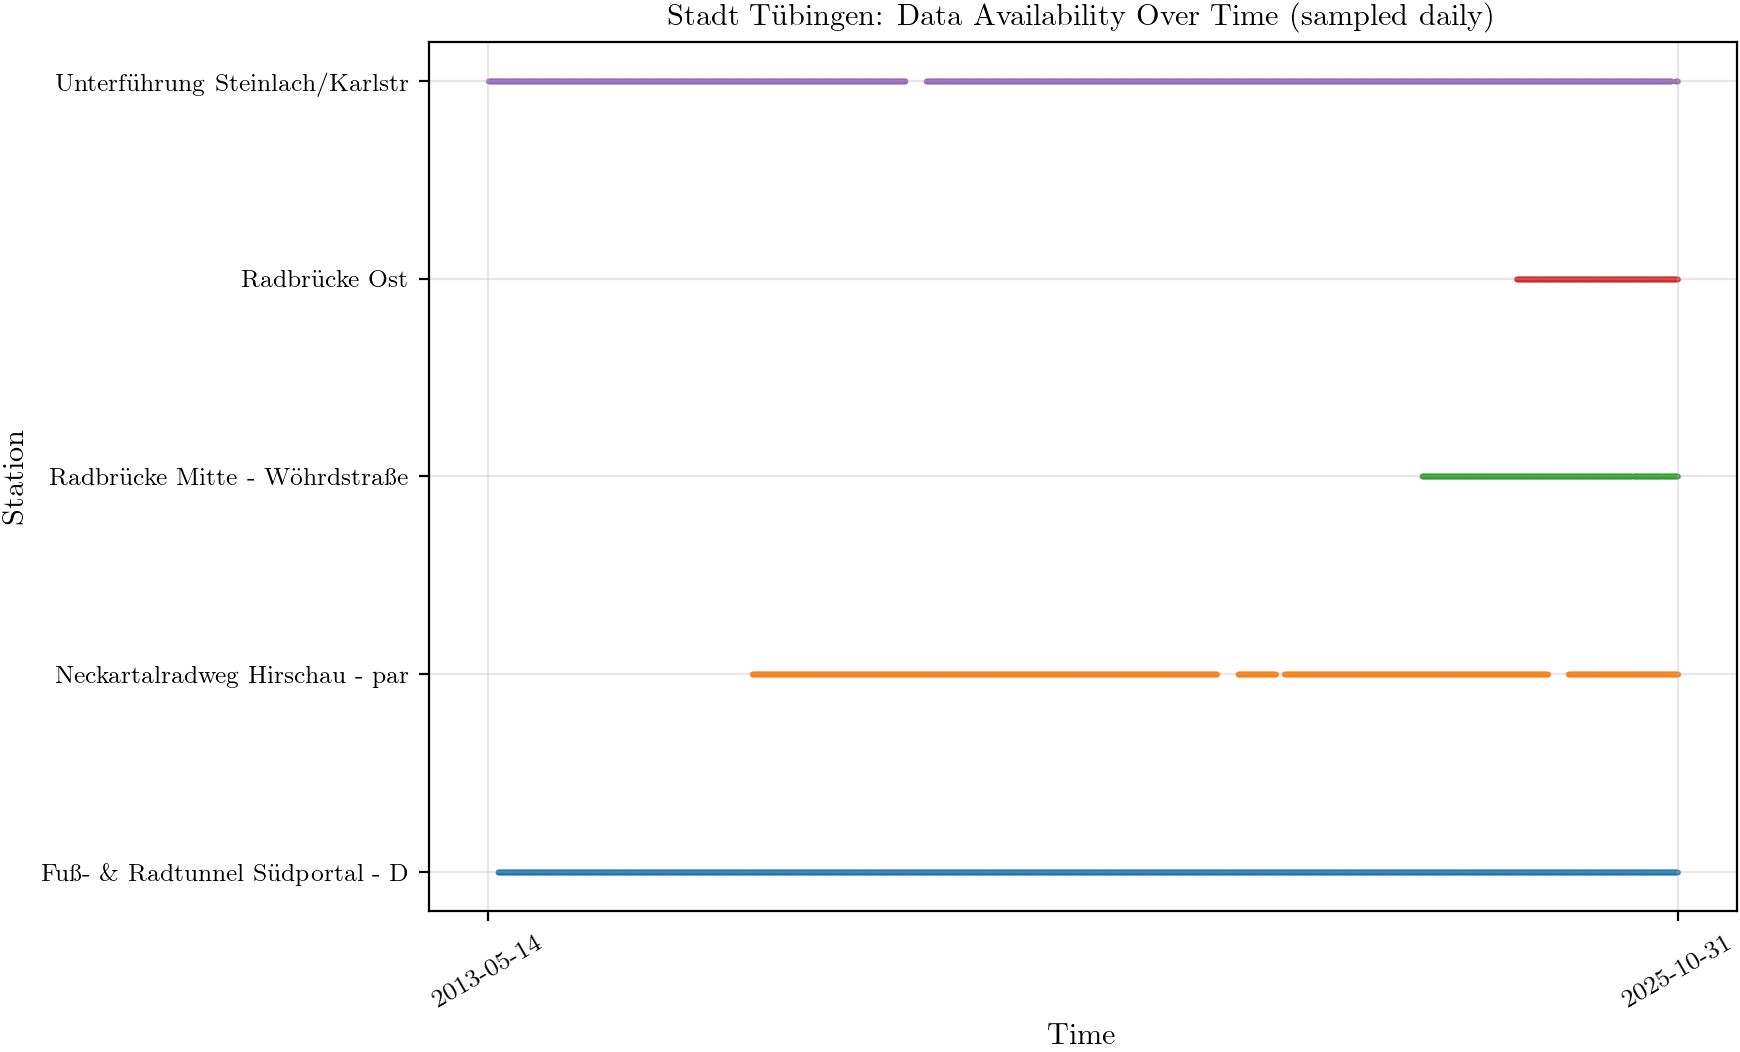


Data Availability Summary:
Total time range: 2013-05-14 22:00:00+00:00 to 2025-10-31 21:00:00+00:00
Total timestamps: 109,110

Timestamps with ALL stations: 12,427 (11.4%)

Per-station coverage:
  Fuß- & Radtunnel Südportal - Derendinger  99.1%
  Neckartalradweg Hirschau - parallel L371  73.6%
  Radbrücke Mitte - Wöhrdstraße             21.4%
  Radbrücke Ost                             13.5%
  Unterführung Steinlach/Karlstraße Südsei  98.0%

Sanity check:
Start window: 2013-05-14 22:00:00+00:00 → 2013-05-21 22:00:00+00:00
  Active stations in first 7 days:   1
  Inactive stations in first 7 days: 4

End window:   2025-10-24 21:00:00+00:00 → 2025-10-31 21:00:00+00:00
  Active stations in last 7 days:    5
  Inactive stations in last 7 days:  0


In [ ]:
################################################
# DATA AVAILABILITY VISUALIZATION              #
################################################
out_dir = os.path.join(PLOTS_DIR, "distcorr")
os.makedirs(out_dir, exist_ok=True)

# Create pivot table to see when each station has data
df_pivot_avail = df_city.pivot_table(
    index='iso_timestamp',
    columns='counter_site',
    values='channels_all',
    aggfunc='count'
)

# Convert index to datetime to avoid categorical axis issues
df_pivot_avail.index = pd.to_datetime(df_pivot_avail.index)

# Convert to binary (1 = has data, 0 = missing)
df_avail_binary = df_pivot_avail.notna().astype(int)

# Sample data for visualization (every 24 hours to avoid overplotting)
df_sample = df_avail_binary.iloc[::24]

with plt.rc_context(get_style(rel_width=1.5, font_adjustment=0, display_dpi=200)):
    # Plot
    fig, ax = plt.subplots()
    ax.set_facecolor("white")
    fig.patch.set_facecolor("white")

    for i, station in enumerate(df_sample.columns):
        # Create line at y=i when data exists
        times = df_sample.index[df_sample[station] == 1]
        if len(times) > 0:
            ax.scatter(times, [i] * len(times), s=1, alpha=0.5)

    # y-axis labels
    ax.set_yticks(range(len(df_sample.columns)))
    ax.set_yticklabels([latex_escape(s[:30]) for s in df_sample.columns], fontsize=9)

    # x-axis: ensure full time range is shown
    start = df_avail_binary.index.min()
    end = df_avail_binary.index.max()

    # Show start and end timestamps as tick labels
    ax.set_xticks([start, end])
    ax.set_xticklabels(
        [start.strftime("%Y-%m-%d"), end.strftime("%Y-%m-%d")],
        rotation=30
    )

    ax.set_xlabel('Time')
    ax.set_ylabel('Station')
    ax.set_title(f'{title_domain}: Data Availability Over Time (sampled daily)')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    # safe figure named after city 
    # # in directory /plots
    out_path = os.path.join(out_dir, f"data_availability_{title_domain}.pdf")
    plt.savefig(out_path, dpi=300)
    plt.show()

# Show statistics
print(f"\nData Availability Summary:")
print(f"Total time range: {df_avail_binary.index.min()} to {df_avail_binary.index.max()}")
print(f"Total timestamps: {len(df_avail_binary):,}")
print(f"\nTimestamps with ALL stations: {df_avail_binary.all(axis=1).sum():,} "
      f"({df_avail_binary.all(axis=1).sum()/len(df_avail_binary)*100:.1f}%)")
print(f"\nPer-station coverage:")
for station in df_avail_binary.columns:
    coverage = df_avail_binary[station].sum() / len(df_avail_binary) * 100
    print(f"  {station[:40]:40} {coverage:5.1f}%")

# --- Sanity check: first & last 7 days ---

# Full range
first_ts = df_avail_binary.index.min()
last_ts  = df_avail_binary.index.max()

# Window definitions
start_window_end = first_ts + pd.Timedelta(days=7)
end_window_start = last_ts  - pd.Timedelta(days=7)

start_window = df_avail_binary[(df_avail_binary.index >= first_ts) &
                               (df_avail_binary.index <= start_window_end)]

end_window = df_avail_binary[df_avail_binary.index >= end_window_start]

# Active if at least one "1" appears in that window
active_start = list(start_window.columns[start_window.sum(axis=0) > 0])
inactive_start = list(start_window.columns[start_window.sum(axis=0) == 0])

active_end = list(end_window.columns[end_window.sum(axis=0) > 0])
inactive_end = list(end_window.columns[end_window.sum(axis=0) == 0])

print("\nSanity check:")
print(f"Start window: {first_ts} → {start_window_end}")
print(f"  Active stations in first 7 days:   {len(active_start)}")
print(f"  Inactive stations in first 7 days: {len(inactive_start)}")

print(f"\nEnd window:   {end_window_start} → {last_ts}")
print(f"  Active stations in last 7 days:    {len(active_end)}")
print(f"  Inactive stations in last 7 days:  {len(inactive_end)}")

In [ ]:
################################################
# TRAIN MODELS FOR ALL STATIONS               #
################################################

all_results = []

for station_idx, station in enumerate(sites1, 1):
    print(f"\n[{station_idx}/{len(sites1)}] {station}")
    
    # Get station data
    df_station = df_city[df_city['counter_site'] == station].copy()
    df_station = df_station.dropna(subset=['channels_all'])
    df_station = df_station.sort_values('iso_timestamp')
    
    # Skip if insufficient data
    if len(df_station) < 1000:
        print(f"    ⊗ Skipped - only {len(df_station)} records")
        continue
    
    # Train model (prints data info internally)
    results, model, features = train_model(df_station, station, df_city)
    
    # Format feature names
    temporal_str = ', '.join(results['temporal_features'])
    weather_str = ', '.join(results['weather_features']) if results['weather_features'] else 'none'
    
    all_results.append(results)
    
    print(f"    Features: {temporal_str} + {weather_str} + {results['n_stations']} station counts = {results['n_features']} total")
    print(f"    Test R² = {results['test_r2']:.4f} | RMSE = {results['test_rmse']:.2f}")

# Create summary DataFrame
results_df = pd.DataFrame(all_results)

print(f"\n{'='*70}")
print(f"SUMMARY - {title_domain}")
print(f"{'='*70}")
print(f"\nAverage Test R²:   {results_df['test_r2'].mean():.4f} ± {results_df['test_r2'].std():.4f}")
print(f"Average Test RMSE: {results_df['test_rmse'].mean():.2f} ± {results_df['test_rmse'].std():.2f}")
print(f"Average Test MAE:  {results_df['test_mae'].mean():.2f} ± {results_df['test_mae'].std():.2f}")

# Print results as markdown table
print(f"\n## Results Table\n")
print("| Station | Test R² | RMSE | MAE | Features |")
print("|---------|---------|------|-----|----------|")
for _, row in results_df.iterrows():
    print(f"| {row['station'][:30]} | {row['test_r2']:.4f} | {row['test_rmse']:.2f} | {row['test_mae']:.2f} | {row['n_features']} |")

# Save results
results_df.to_csv(f'regression_results_{title_domain.replace(" ", "_")}.csv', index=False)
print(f"\n✓ Saved: regression_results_{title_domain.replace(' ', '_')}.csv")


[1/5] Fuß- & Radtunnel Südportal - Derendinger Allee
    Complete coverage: 12,427/109,110 hours (11.4%)
    Time frame: 2024-02-21 12:00:00+00:00 to 2025-10-31 01:00:00+00:00 (617 days, 12,427 hours)
    Features: hour, day_of_week, month + none + 4 station counts = 7 total
    Test R² = 0.9137 | RMSE = 56.91

[2/5] Neckartalradweg Hirschau - parallel L371
    Complete coverage: 12,427/109,110 hours (11.4%)
    Time frame: 2024-02-21 12:00:00+00:00 to 2025-10-31 01:00:00+00:00 (617 days, 12,427 hours)
    Features: hour, day_of_week, month + none + 4 station counts = 7 total
    Test R² = 0.2425 | RMSE = 36.92

[3/5] Radbrücke Mitte - Wöhrdstraße
    Complete coverage: 12,427/109,110 hours (11.4%)
    Time frame: 2024-02-21 12:00:00+00:00 to 2025-10-31 01:00:00+00:00 (617 days, 12,427 hours)
    Features: hour, day_of_week, month + none + 4 station counts = 7 total
    Test R² = 0.5465 | RMSE = 61.16

[4/5] Radbrücke Ost
    Complete coverage: 12,427/109,110 hours (11.4%)
    Time fr